In [123]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
import shap
import itertools
import math


In [2]:
data = pd.read_csv('ligue1_clean.csv')
data.head()

,Season,MatchID,Date,Time,Round,Day,Venue,Result,GF,GA,...,Dribles Challenged,Dribbles tackled %,Challenges Lost,Total Blocks,Shots Blocked,Passs Blocked,Interceptions,Tackles Plus Interceptions,Clearances,Errors Leading to Shot
0,2023-2024,Paris Saint Germain_Lorient,2023-08-12,21:00,1,Sat,Home,D,0.0,0.0,...,6.0,50.0,3.0,9.0,1.0,8.0,8.0,18,6.0,0.0
1,2023-2024,Paris Saint Germain_Toulouse,2023-08-19,21:00,2,Sat,Away,D,1.0,1.0,...,14.0,64.3,5.0,10.0,2.0,8.0,6.0,20,6.0,0.0
2,2023-2024,Paris Saint Germain_Lens,2023-08-26,21:00,3,Sat,Home,W,3.0,1.0,...,10.0,40.0,6.0,10.0,1.0,9.0,4.0,19,11.0,1.0
3,2023-2024,Paris Saint Germain_Lyon,2023-09-03,20:45,4,Sun,Away,W,4.0,1.0,...,29.0,48.3,15.0,11.0,4.0,7.0,2.0,21,14.0,1.0
4,2023-2024,Paris Saint Germain_Nice,2023-09-15,21:00,5,Fri,Home,L,2.0,3.0,...,18.0,61.1,7.0,12.0,4.0,8.0,6.0,24,3.0,2.0


In [3]:
print(list(data.columns))
data.Team.nunique()

data=data[['Team', 'Opponent', 'Poss', 'GF', 'xG', 'Fouls Drawn', 'Ball Recoveries','Aerial Duels Won %', 'Passes Completed %','Short Pass Completion %', 'Medium Pass Completion %','Long Pass Completion %','Passes into Final Third', 'Passes into Penalty Area', 'Crosses into Penalty Area', 'Progressive Passes','Total Shots', 'Shots on Target','Free Kicks Taken','Penalty Kicks Attempted', 'Touches in Defensive Penalty Area', 'Touches in Defensive Third', 'Touches in Midfield Third', 'Touches in Attacking Third', 'Touches in Attacking Penalty Area','Successful Take_Ons','Progressive Carries', 'Carries into Final Third','Carries into Penalty Area', 'Through Balls', 'Switches', 'Crosses', 'Corner Kicks']]

['Season', 'MatchID', 'Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA', 'Opponent', 'xG', 'xGA', 'Poss', 'Attendance', 'Captain', 'Formation', 'Referee', 'Team', 'Yellow Cards', 'Red Cards', 'Second Yellow Cards', 'Fouls Committed', 'Fouls Drawn', 'Offsides', 'Own Goals', 'Ball Recoveries', 'Aerial Duels Won', 'Aerial Duels Lost', 'Aerial Duels Won %', 'Passes Completed %', 'Total Passing Distance', 'Progressive Passing Distance', 'Short Passes Completed', 'Short Passes Attempted', 'Short Pass Completion %', 'Medium Passes Completed', 'Medium Passes Attempted', 'Medium Pass Completion %', 'Long Passes Completed', 'Long Passes Attempted', 'Long Pass Completion %', 'Assists', 'Expected Assists Goals', 'Expected Assists', 'Key Passes', 'Passes into Final Third', 'Passes into Penalty Area', 'Crosses into Penalty Area', 'Progressive Passes', 'Total Shots', 'Shots on Target', 'Shots on Target %', 'Goals per Shot', 'Goals per Shot on Target', 'Average Shot Distance', 'Free Kicks 

In [4]:
data_coalition = dict()

for team in list(data.Team.unique()):
    data_coalition[team] = data[data.Team == team]



In [5]:
data_test= data.drop(['Team', 'Opponent'], axis=1)
data_test = data_test.dropna()
X_train, X_test, y_train, y_test = train_test_split(data_test.drop(['xG'], axis=1), data_test.xG, test_size=0.2, random_state=123)

In [6]:
# Définir les paramètres du modèle
params = {
    'max_depth': 5,  # profondeur maximale de l'arbre
    'learning_rate': 0.1,  # taux d'apprentissage
    'num_parallel_tree': 100,  # nombre d'estimateurs (nombre d'arbres)
    'random_state': 42, # graine pour la reproductibilité
    'objective': 'reg:squarederror'  # Utiliser la fonction de perte appropriée pour la régression
}

In [9]:

# Définir les paramètres du modèle
params = {
    'max_depth': 3,  # profondeur maximale de l'arbre
    'learning_rate': 0.1,  # taux d'apprentissage
    'num_parallel_tree': 100,  # nombre d'estimateurs (nombre d'arbres)
    'random_state': 42, # graine pour la reproductibilité
    'objective': 'reg:squarederror'  # Utiliser la fonction de perte appropriée pour la régression
}

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}


xgb_model = xgb.XGBRegressor()
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1,
)




In [12]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=0)

# Adapter les données d'entraînement
grid_search.fit(X_train, y_train)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [13]:
model = xgb.XGBRegressor(**params).fit(X_train, y_train)


In [14]:

y_pred1= model.predict(X_test)

mse2 = mean_squared_error(y_test, y_pred1)
model.score(X_test, y_test)

0.7347870094429335

In [15]:
mse2

0.14948384420429875

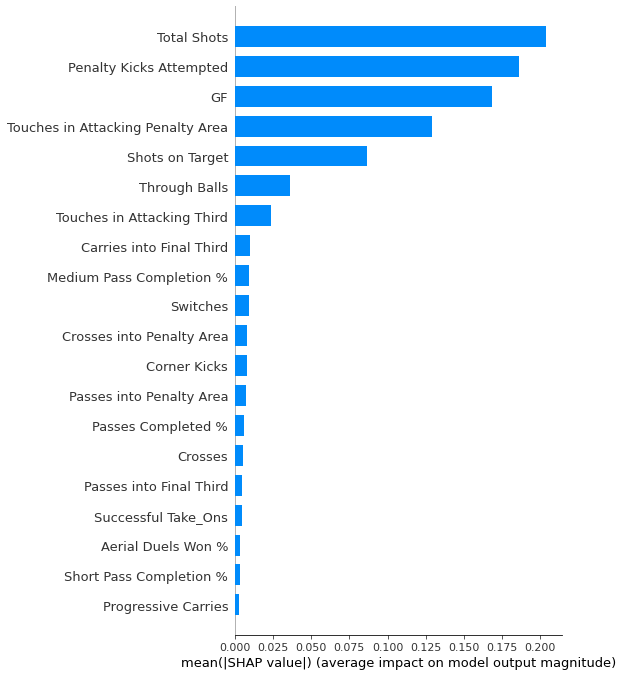

In [13]:
shape = shap.TreeExplainer(model)   
shape_values = shape.shap_values(X_test)
shap.summary_plot(shape_values, X_test, plot_type="bar")

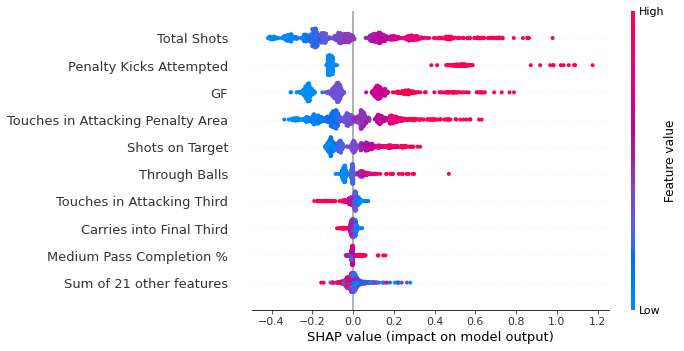

In [14]:
pred = model.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()
shap.plots.beeswarm(explanation)


In [ ]:

X_cons = add_constant(X_train)

model = OLS(y_train, X_cons)
results = model.fit()
print(results.summary())

/Users/eudeslocqueville/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     xG   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     346.9
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        18:52:34   Log-Likelihood:                -2014.4
No. Observations:                3932   AIC:                             4091.
Df Residuals:                    3901   BIC:                             4285.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [ ]:
X_test_cons = add_constant(X_test)

y_pred = results.predict(X_test_cons)

mse=mean_squared_error(y_test, y_pred)
mse


/Users/eudeslocqueville/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


0.15237601339533263

## Algorithme DU-Shapley 

In [127]:



def utility_function(dataset):
    if dataset.shape[0] == 0:
        return 0
    dataset= dataset.drop(['Team', 'Opponent'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['xG'], axis=1), dataset.xG, test_size=0.2, random_state=123)
    model = xgb.XGBRegressor(**params).fit(X_train, y_train)
    return model.score(X_test, y_test)

def du_shapley(data_coalition, I):
    RET = {}
    for i in I:
        # Exclude the i-th dataset
        D_i = data_coalition[i]
        D_minus_i = pd.concat([data_coalition[j] for j in I if j != i])

        mu_minus_i = len(D_minus_i) // (len(I)-1)
        RET_i = 0
        
        for k in range(len(I)):
            # Sample k * mu_minus_i elements from D_minus_i
            D_sample = D_minus_i.sample(n = k * mu_minus_i)
            # Calculate the marginal gain
            marginal_gain = utility_function(pd.concat([D_sample,D_i])) - utility_function(D_sample)
            RET_i += marginal_gain
        
        RET_i /= (len(I)-1)
        RET[i] = RET_i
    
    return RET

# I= data.Team.unique()
# result = du_shapley(data_coalition, I)
# print(result)


In [132]:
def shapley_value(I, player_index, player_dict):
    player_data = player_dict.pop(player_index)
    gain = 0

    for perm in itertools.permutations(itertools.chain(range(1, player_index), range(player_index + 1, I + 1))): 
        concat1 = pd.concat([player_dict[j] for j in perm])
        concat2 = pd.concat([concat1, player_data])
        marginal_gain = utility_function(concat2) - utility_function(concat1)
        
        gain += marginal_gain * (math.factorial(len(perm)) * math.factorial(I - len(perm) - 1) / math.factorial(I - 1))

    return gain / I

In [134]:

dict = {
    1: data[data['Team'].isin(['Lyon', 'Paris Saint Germain'])],
    2: data[data.Team == 'Marseille'],
    3: data[data.Team == 'Lille'],
    4: data[data['Team'].isin(['Nice', 'Angers', 'Monaco'])],
    5: data[data['Team'].isin(['Montpellier', 'Brest', 'Lens', 'Toulouse'])],
}

for i in range(1, 6):
    print(f"Shapley value for player {i}: {shapley_value(5, i, dict)}")


In [ ]:
du_shapley(dict,[1,2,3,4,5])

In [103]:
def monte_carlo_shapley(I, player_index, player_dict, num_samples=1000):
    player_data = player_dict.pop(player_index)
    gain = 0

    for _ in range(num_samples):
        perm = np.random.permutation(range(1, I + 1))
        concat1 = pd.concat([player_dict[j] for j in perm])
        concat2 = pd.concat([concat1, player_data])
        marginal_gain = utility_function(concat2) - utility_function(concat1)
        gain += marginal_gain

    return gain / num_samples

<function dict.keys>